In [153]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import root
from scipy.linalg import block_diag
import h5py
import os
import itertools
import pandas as pd
import gvar as gv
import lsqfit
from utils import *

import matplotlib.patches as mpatches

import sys
sys.path.append('/Users/theoares/lqcd/utilities')
from fittools import *
from formattools import *
import plottools as pt

# Will imports
import data_io_nn as io
sys.path.append('/Users/theoares/lqcd_analysis')
from lqcd_analysis import visualize as wplt
from lqcd_analysis import correlator
from lqcd_analysis import analysis
from lqcd_analysis import statistics as stats

style = styles['prd_twocol']
pt.set_font()

The three-point data is stored in 21 columns. The first three are the source, sink, and operator separation, and the remaining 9 are the operators. Note that for the 2-point functions, there are $T^2$ timeslice pairs that index each configuration, where $T$ is the lattice size. For the three-point data, 

In [2]:
L, T = 32, 48
runs = ['A', 'B', 'C', 'D', 'E', 'F']
data_dir = '/Users/theoares/Dropbox (MIT)/research/0nubb/nnpp/data/raw'
# data_dir = '/Users/theoares/Dropbox (MIT)/research/0nubb/nnpp/data'
all_dirs = [f'{data_dir}/run_{r}' for r in runs]
twopt_fname = 'dinucleon-2pt-WP'
threept_fname = 'nnpp-3pt'

### Read in data

In [42]:
# 2-point I/O functions
def read_2pt(fname, cfg_offset = 0):
    """
    Two-point data from all configurations is concatenated together, with data
    from each configuration appearing in successive blocks.
    Each block consists of nt*nt total lines.
    The total number of lines in the file is nt*nt*nconfigs.
    """
    dataframe = pd.read_csv(fname, sep='\s+', header=None, names=['t-','t+', 're', 'im'])
    
    nt = len(dataframe['t+'].unique())
    nsrc = len(dataframe['t-'].unique())
    ntimes = len(dataframe.groupby(['t-','t+']).size())
    
    assert ntimes == nt * nsrc, 'Full T x T timeslices not in dataframe.'
    
    if (len(dataframe) % ntimes) != 0:
        print("Unexpected data size.")
    nlines = len(dataframe)
    if (nlines % ntimes == 0):
        nconfigs = nlines // ntimes
    else:
        print("Bad line count?")
        
    dataframe['config'] = np.repeat(np.arange(nconfigs), repeats=ntimes) + cfg_offset
    dataframe['C2'] = dataframe['re'] + 1j*dataframe['im']
    dataframe = dataframe.drop(columns = ['re', 'im'])
    
    dataframe = dataframe.groupby(['t-', 't+', 'config']).mean().reset_index()
    
    if (len(dataframe) % (nt*nsrc) != 0):
        print("Unexpected line count:", len(dataframe))
    return dataframe

def avg_src_2pt(dataframe):
    """
    Average over the source times on each configuration.
    """
    nt = len(dataframe['t'].unique())
    nsrc = len(dataframe['source'].unique())
    if (len(dataframe) % (nt*nsrc)) != 0:
        print("Unexpected data size.")
    ncfg = len(dataframe) // (nt * nsrc)
    # Average over source times
    dataframe['config'] = np.repeat(np.arange(ncfg), nsrc*nt)
    dataframe = dataframe.groupby(['config','t'])['re'].mean().reset_index()
    # Reshape to (nconfigs, nt)
    return np.vstack(dataframe.groupby('t')['re'].apply(np.array).values).T

In [62]:
# 3-point I/O functions
ops = ['SS', 'PP', 'VV', 'AA', 'TT', 'VS', 'AP', 'VT', 'AT']
def read_3pt(fname, cfg_offset = 0):
    #col_names = ['t-', 't+', 'delta']
    col_names = ['sep', 'tm', 't']
    for op in ops:
        col_names.extend([f'{op}_re', f'{op}_im'])
    dataframe = pd.read_csv(fname, sep = '\s+', header=None, names = col_names)
    #ntimes = len(dataframe.groupby(['t-','t+','delta']).size())
    ntimes = len(dataframe.groupby(['sep', 'tm', 't']).size())
    if (len(dataframe) % ntimes) != 0:
        print("Unexpected data size.")
    nlines = len(dataframe)
    if (nlines % ntimes == 0):
        nconfigs = nlines // ntimes
    else:
        print("Bad line count?")
    dataframe['config'] = np.repeat(np.arange(nconfigs), repeats = ntimes) + cfg_offset
    for op in ops:
        dataframe[op] = dataframe[f'{op}_re'] + 1j*dataframe[f'{op}_im']
        dataframe = dataframe.drop(columns = [f'{op}_re', f'{op}_im'])
    #dataframe = dataframe.groupby(['t-', 't+', 'delta', 'config']).mean().reset_index()
    dataframe = dataframe.groupby(['sep', 'tm', 't', 'config']).mean().reset_index()
    return dataframe

In [ ]:
# def compute_ratio4(c2, df4):

#     # Add useful time separations
#     df4['t-'] = df4['tsrc'] - df4['top2']
#     df4['t+'] = df4['tsnk'] - df4['top2']
#     df4['v'] = df4['top1'] - df4['top2']
#     df4['dt'] = df4['t+'] - df4['t-']
#     df4['dt+'] = df4['t+'] - df4['v'].apply(lambda val: max(val, 0))
#     df4['dt-'] = df4['v'].apply(lambda val: min(val, 0)) - df4['t-']
#     df4['|v|'] = df4['v'].apply(np.abs)

#     # Compute the ratio "C4/C2"
#     # this is a slick way to get the ratio... divide C4 by C2[dt] where dt is accessed in the df4 DataFrame
#     df4['ratio'] = df4['re'] / df4['dt'].apply(lambda dt: c2[dt])
#     return df4

def compute_ratio(c2, df3):

    # Add useful time separations
    df4['t-'] = df4['tsrc'] - df4['top2']
    df4['t+'] = df4['tsnk'] - df4['top2']
    df4['v'] = df4['top1'] - df4['top2']
    df4['dt'] = df4['t+'] - df4['t-']
    df4['dt+'] = df4['t+'] - df4['v'].apply(lambda val: max(val, 0))
    df4['dt-'] = df4['v'].apply(lambda val: min(val, 0)) - df4['t-']
    df4['|v|'] = df4['v'].apply(np.abs)

    # Compute the ratio "C4/C2"
    # this is a slick way to get the ratio... divide C4 by C2[dt] where dt is accessed in the df4 DataFrame
    df4['ratio'] = df4['re'] / df4['dt'].apply(lambda dt: c2[dt])
    return df3

# def correlate_ratio4(df2, df4, ntimes=24):
#     arr2 = df2[range(ntimes)].values    # all 2-point corr data as an array (n_cfgs, ntimes)
#     tmp = df4.groupby(['tsrc', 'top1', 'top2','tsnk'])['re'].apply(np.array)
#     arr4 = np.vstack(tmp.values).T

#     # Correlate 2pt and 4pt results
#     ds = gv.dataset.avg_data({'c2': arr2, 'c4': arr4})

#     # Repackage 4pt to DataFrame
#     df4 = tmp.keys().to_frame().reset_index(drop=True)
#     df4['re'] = ds['c4']
#     # correlated gvar dataset for c4 repackaged into df4['re']

#     # Compute ratio, including correlations
#     return compute_ratio(ds['c2'], df4)

def correlate_ratio(df2, df3, ntimes = 24):
    arr2 = df2[range(ntimes)].values    # all 2-point corr data as an array (n_cfgs, ntimes)
    tmp = df4.groupby(['tsrc', 'top1', 'top2','tsnk'])['re'].apply(np.array)
    arr4 = np.vstack(tmp.values).T

    # Correlate 2pt and 4pt results
    ds = gv.dataset.avg_data({'c2': arr2, 'c4': arr4})

    # print(ds['c2'])
    # print(ds['c4'])
    # ds['c2'] and ds['c4'] contain gvar objects with the correlator which have all the respective 
    # means and covariances stored there

    # Repackage 4pt to DataFrame
    df4 = tmp.keys().to_frame().reset_index(drop=True)
    df4['re'] = ds['c4']
    # correlated gvar dataset for c4 repackaged into df4['re']

    # Compute ratio, including correlations
    return compute_ratio(ds['c2'], df4)

In [39]:
# # read in 2pts
# data_dir = '/Users/theoares/Dropbox (MIT)/research/0nubb/nnpp/data/raw'
# twopt_fname = 'dinucleon-2pt-WP'

# L, T = 32, 48
# runs = ['A', 'B', 'C', 'D', 'E', 'F']
# # runs = ['C', 'D', 'E', 'F']
# root = '/Users/theoares/Dropbox (MIT)/research/0nubb/nnpp/data/raw/run_{run}/'

# # TODO should edit how this is done so I can correlate it with C3
# corrs = {}
# data = {}
# tcut = 24
# # for tag in tags:
# #     print(f"Reading {tag}")
# data_tmp = []  # accumulate data across runs
# for run in runs:
#     fname = os.path.join(root.format(run=run), twopt_fname)
#     try:
#         raw = io.read_2pt(fname)
#     except FileNotFoundError:
#         print(f"--> Missing {run}")
#         continue
    
#     arr = io.avg_src_2pt(raw)
#     arr = arr[:, :tcut]
#     if tag == "nucleon-2pt-WP":
#         arr = -1*arr
#     print(f"--> {run} {arr.shape}")
#     data_tmp.append(arr)
# data['C2'] = np.vstack(data_tmp)
# ds = gv.dataset.avg_data(data)
    
# # Normalize
# for key in ds:
#     ds[key] = ds[key] / gv.mean(ds[key][0])

--> A (618, 24)
--> B (1029, 24)
--> C (1057, 24)
--> D (3524, 24)
--> E (2871, 24)
--> F (3040, 24)


In [44]:
# read in 2pts
data_dir = '/Users/theoares/Dropbox (MIT)/research/0nubb/nnpp/data/raw'
twopt_fname = 'dinucleon-2pt-WP'

L, T = 32, 48
runs = ['A', 'B', 'C', 'D', 'E', 'F']
# runs = ['C', 'D', 'E', 'F']
root = '/Users/theoares/Dropbox (MIT)/research/0nubb/nnpp/data/raw/run_{run}/'

In [50]:
# read in 2pts
offset = 0
dfs = []
for run in runs:
    print('Reading data for run', run)
    datadir = root.format(run=run)
    fname = os.path.join(datadir, twopt_fname)
    df = read_2pt(fname, cfg_offset = offset)
    offset = np.max(df['config']) + 1
    dfs.append(df)
df2 = pd.concat(dfs, axis = 0)

Reading data for run A
Reading data for run B
Reading data for run C
Reading data for run D
Reading data for run E
Reading data for run F


In [63]:
# read in 3pts
threept_fname = 'nnpp-3pt'
offset = 0
dfs = []
for run in runs:
    print('Reading data for run', run)
    datadir = root.format(run=run)
    fname = os.path.join(datadir, threept_fname)
    df = read_3pt(fname, cfg_offset = offset)
    offset = np.max(df['config']) + 1
    dfs.append(df)
df3 = pd.concat(dfs, axis = 0)

Reading data for run A
1026
Reading data for run B
1026


KeyboardInterrupt: 

Some relevant pieces from the code:
- sep (source-operator separation) should be in $[6, 23]$.
- Have $sep = \mathrm{(sink time)} - \mathrm{(operator time)}$
- $tp$ = time position of point sinks, runs from 0 to $n_t$.
- PRINTING PATTERN: First 3 columns are $(sep, tm, t)$. 

Time ranges:
- $sep$: source-sink separation
- $tm$ : source position (wall)
- $tp$ : sink position (point)
- $t$ : operator time - source time. Source-operator and sink-operator separation must be $\geq 3$ lattice spacings.

Time ranges and identities:
- Source-sink separation: $6\leq sep \leq 23$
- $tm = (T + tp - sep) \% T$, i.e. you take $tp - sep$ and make it respect your boundary conditions.
- $0\leq tp\leq T - 1$, spaced by $sink\_sep = 8$. 
- $3\leq t \leq sep - 3$

In [65]:
df3[(df3['config'] == 1) & (df3['sep'] == 7)][['sep', 'tm', 't']]

,sep,tm,t
3709,7,1,3
4327,7,1,4
4945,7,9,3
5563,7,9,4
6181,7,17,3
6799,7,17,4
7417,7,25,3
8035,7,25,4
8653,7,33,3
9271,7,33,4


In [58]:
df3

,sep,tm,t,config,SS,PP,VV,AA,TT,VS,AP,VT,AT
0,6,2,3,0,1.853259e-03+7.995656e-04j,-5.758775e-03-1.797355e-03j,-4.612050e-03-1.597843e-03j,-4.906277e-03-2.048843e-03j,-7.539458e-03-2.566135e-03j,1.741960e-04-1.017506e-04j,-9.619007e-04-2.004995e-04j,1.225898e-04+1.644629e-04j,-1.255074e-03-4.927226e-04j
1,6,2,3,1,9.305339e-04+1.153962e-04j,-3.689404e-03+1.008369e-03j,-4.119520e-03+1.400380e-03j,-5.386953e-03+9.300908e-04j,-6.832597e-03+1.839054e-03j,-1.877018e-04+2.802386e-04j,-8.458108e-04+7.364056e-04j,-4.215160e-05-6.764201e-05j,-1.427832e-03+1.480716e-04j
2,6,2,3,2,1.064656e-03+6.773628e-05j,-4.864433e-03-3.217721e-04j,-5.665909e-03-1.206786e-03j,-5.573611e-03-1.187970e-03j,-8.963457e-03-1.454549e-03j,-5.443273e-04-8.153955e-05j,-1.796964e-03-2.123137e-04j,1.115419e-04-1.060915e-04j,-2.032380e-03-4.993191e-04j
3,6,2,3,3,1.441769e-03+1.332168e-03j,-4.820997e-03-1.301566e-03j,-4.963722e-03+1.383422e-04j,-4.633242e-03+7.285516e-04j,-7.531408e-03+9.545011e-05j,1.544118e-04+5.778172e-04j,-1.050187e-03-6.261289e-05j,-8.614325e-05-7.331930e-05j,-1.228698e-03-6.541375e-05j
4,6,2,3,4,1.424879e-03-4.332451e-04j,-7.481233e-03+6.588549e-04j,-9.462208e-03+1.645358e-03j,-1.038929e-02-3.066316e-04j,-1.440159e-02+1.983745e-04j,-3.826638e-04+1.427157e-05j,-1.960570e-03+1.195095e-04j,8.952807e-05+2.788875e-05j,-2.555025e-03-6.285154e-04j
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3119035,23,41,20,12134,2.348258e-17+1.433624e-17j,2.018525e-17-2.517103e-17j,2.702743e-17-3.990884e-18j,4.984861e-17-2.383142e-17j,6.021792e-17-5.936912e-18j,1.419547e-17-1.690158e-18j,-1.297132e-18-8.434740e-18j,-8.160209e-18-7.249556e-18j,-3.982069e-17+2.062315e-17j
3119036,23,41,20,12135,3.358776e-17+2.437728e-17j,-1.218904e-19-1.523752e-17j,8.008386e-18-5.313976e-17j,-1.559039e-17+7.385855e-18j,-4.375041e-17-2.322299e-17j,2.182780e-17+5.886620e-18j,-1.210923e-17+5.487034e-19j,-1.627762e-17+1.778328e-17j,3.590371e-17+1.370825e-17j
3119037,23,41,20,12136,5.547819e-17-1.818734e-17j,-4.463495e-17+4.453730e-17j,-3.187664e-17-7.893329e-17j,1.305911e-17-2.684644e-17j,-5.479077e-17-5.864204e-17j,6.697103e-18-2.586079e-17j,-1.044028e-17-3.011809e-17j,-1.733419e-17-3.541512e-17j,1.967067e-17+4.234034e-17j
3119038,23,41,20,12137,3.909603e-17+2.647909e-17j,-8.355937e-19-5.415917e-17j,5.249970e-18-3.583278e-17j,3.797047e-17-3.569824e-17j,1.533878e-17-7.538018e-17j,1.729324e-17+1.755436e-17j,2.621627e-17+9.061048e-18j,-3.096201e-18+3.355038e-17j,3.179257e-18-2.774393e-18j


In [23]:
len(df3['config'].unique())

12139

In [11]:
ds['C2']

array([1.00000(12), 0.261047(45), 0.042575(12), 0.0055849(23),
       0.00064486(37), 0.000068570(53), 6.9033(70)e-06, 6.7006(88)e-07,
       6.347(11)e-08, 5.927(14)e-09, 5.438(19)e-10, 4.953(27)e-11,
       4.491(41)e-12, 4.151(66)e-13, 3.82(11)e-14, 3.34(18)e-15,
       3.00(30)e-16, 2.75(49)e-17, 3.61(82)e-18, 3.7(1.4)e-19,
       4.5(2.4)e-20, 1.2(4.0)e-21, -2.4(6.9)e-22, 8(13)e-23], dtype=object)

## Old I/O under here... probably make a new one

In [ ]:
L, T = 32, 48
runs = ['A', 'B', 'C', 'D', 'E', 'F']
data_dir = '/Users/theoares/Dropbox (MIT)/research/0nubb/nnpp/data/raw'
# data_dir = '/Users/theoares/Dropbox (MIT)/research/0nubb/nnpp/data'
all_dirs = [f'{data_dir}/run_{r}' for r in runs]
twopt_fname = 'dinucleon-2pt-WP'
threept_fname = 'nnpp-3pt'

In [42]:
def parse_twopt_csv(fname, cur_cfg = 0):
    """
    Parses the two-point CSV function given by fname. Returns a Pandas dataframe with columns 
        ['cfg', 't-', 't+', 'C2'] 
    and the number of configurations read in.
    
    Parameters
    ----------
    fname : str
        Name of file to parse. Each row should be deliminated by white space. 
    cur_cfg : int (default = 0)
        Current configuration. Starts the indexing for the 'cfg' column at cur_cfg, and adds 1 for each configuration.
    
    Returns
    -------
    df2 : pd.Dataframe
        Dataframe containing the information in the file, with columns ['cfg', 't-', 't+', 'C2'].
    N : int
        Number of configurations in the file.
    """
    n_time_pairs = T**2
    df2 = pd.read_table(fname, delim_whitespace = True, names = ['t-', 't+', 're', 'im'])
    df2['C2'] = df2['re'] + (1j)*df2['im']
    df2 = df2.drop(columns = ['re', 'im'])
    N = len(df2) // n_time_pairs
    
    print(len(df2))
    print(N)
    
    cfg_series = pd.Series(
        np.array([[cur_cfg + ii] * n_time_pairs for ii in range(N)]).flatten()
    )
    df2.insert(0, 'cfg', cfg_series)
    return df2, N

def parse_threept_csv(fname, ops = ['SS', 'PP', 'VV', 'AA', 'TT', 'VS', 'AP', 'VT', 'AT'], cur_cfg = 0, N = -1):
    """
    Parses the three-point CSV function given by fname. Returns a Pandas dataframe with columns 
        ['cfg', 't-', 't+', 'delta', 'SS', 'PP', 'VV', 'AA', 'TT', 'VS', 'AP', 'VT', 'AT']
    and the number of configurations read in.
    
    Parameters
    ----------
    fname : str
        Name of file to parse. Each row should be deliminated by white space. 
    ops : [str]
        Operator names to parse. Defaults to the entire operator list.
    cur_cfg : int (default = 0)
        Current configuration. Starts the indexing for the 'cfg' column at cur_cfg, and adds 1 for each configuration.
    N : int (default = -1)
        Number of configurations the file has. If -1, assumes this is not yet specified and returns it. 
        If specified, asserts that the file indeed corresponds to this many configurations.
    
    Returns
    -------
    df3 : pd.Dataframe
        Dataframe containing the information in the file, with columns 
            ['cfg', 't-', 't+', 'delta', 'SS', 'PP', 'VV', 'AA', 'TT', 'VS', 'AP', 'VT', 'AT'].
    N : int
        Number of configurations in the file.
    time_idxs : np.array [n_time_tups, 3]
        Value of unique time tuples (t-, t+, delta) on each configuration.
    """
    col_names = ['t-', 't+', 'delta']
    for op in ops:
        col_names.extend([f'{op}_re', f'{op}_im'])
    df3 = pd.read_table(fname, delim_whitespace = True, names = col_names)
    for op in ops:
        df3[op] = df3[f'{op}_re'] + 1j*df3[f'{op}_im']
        df3 = df3.drop(columns = [f'{op}_re', f'{op}_im'])
    time_idxs = np.unique(np.array(df3[['t-', 't+', 'delta']]), axis = 0)
    n_time_tups = time_idxs.shape[0]
    if N >= 0:
        assert N == len(df3) // n_time_tups, 'Number of configs does not match data in file.'
    else:
        N = len(df3) // n_time_tups
    cfg_series = pd.Series(
        np.array([[cur_cfg + ii] * n_time_tups for ii in range(N)]).flatten()
    )
    df3.insert(0, 'cfg', cfg_series)
    return df3, N, time_idxs

In [44]:
df2, df3 = pd.DataFrame(), pd.DataFrame()
n_cfgs = 0
n_cfgs_per_stream = []
for directory in all_dirs:
    print(f'Parsing directory {directory}.')
    tmp_df2, tmp_n = parse_twopt_csv(f'{directory}/{twopt_fname}', cur_cfg = n_cfgs)
    df2 = pd.concat([df2, tmp_df2], axis = 0)
    tmp_df3, _, time_idxs = parse_threept_csv(f'{directory}/{threept_fname}', cur_cfg = n_cfgs, N = tmp_n)
    df3 = pd.concat([df3, tmp_df3], axis = 0)
    n_cfgs += tmp_n
    n_cfgs_per_stream.append(tmp_n)
n_time_tups = time_idxs.shape[0]
assert n_cfgs == np.sum(np.array(n_cfgs_per_stream)), 'Wrong number of configurations measured.'
assert len(df2) == n_cfgs * (T**2), 'Wrong number of rows in df2.'
assert len(df3) == n_cfgs * n_time_tups, 'Wrong number of rows in df3.'

Parsing directory /Users/theoares/Dropbox (MIT)/research/0nubb/nnpp/data/short_distance/run_A.
1423872
618
Parsing directory /Users/theoares/Dropbox (MIT)/research/0nubb/nnpp/data/short_distance/run_B.
2370816
1029
Parsing directory /Users/theoares/Dropbox (MIT)/research/0nubb/nnpp/data/short_distance/run_C.
2435328
1057
Parsing directory /Users/theoares/Dropbox (MIT)/research/0nubb/nnpp/data/short_distance/run_D.
8119296
3524
Parsing directory /Users/theoares/Dropbox (MIT)/research/0nubb/nnpp/data/short_distance/run_E.
6614784
2871
Parsing directory /Users/theoares/Dropbox (MIT)/research/0nubb/nnpp/data/short_distance/run_F.
7004160
3040


In [46]:
df2['cfg']

0              0
1              0
2              0
3              0
4              0
           ...  
7004155    12138
7004156    12138
7004157    12138
7004158    12138
7004159    12138
Name: cfg, Length: 27968256, dtype: int64

In [47]:
np.max(df3['cfg'])

12138

In [51]:
# for ii in range(n_cfgs):
#     subdf = df3[df3['cfg'] == ii]
#     assert len(subdf) == n_time_tups, 'Wrong number of time tuples'

In [50]:
n_time_tups

1026

In [49]:
len(df3[df3['cfg'] == 12138])

1026

In [28]:
np.min(df3[(df3['t-'] == 23) & (df3['t+'] == 41)]['cfg'])

0

In [ ]:
time_idxs2 = []
for tm, tp, delta in itertools.product(range(6, 24), range(2, 41))

In [14]:
print(time_idxs)

[[ 6  2  3]
 [ 6 10  3]
 [ 6 18  3]
 ...
 [23 41 18]
 [23 41 19]
 [23 41 20]]


In [15]:
print(n_cfgs_per_stream)

[618, 1029, 1057, 3524, 2871, 3040]


In [16]:
print(n_cfgs)

12139


In [9]:
df2

,cfg,t-,t+,C2
0,0,0,0,4.348528e+04+6.757847e+02j
1,0,0,1,1.130591e+04+3.069902e+02j
2,0,0,2,2.063066e+03-3.679312e+01j
3,0,0,3,3.159597e+02-1.201988e+01j
4,0,0,4,2.812497e+01-2.905247e+00j
...,...,...,...,...
7004155,12138,47,43,-2.227391e-12-2.720316e-12j
7004156,12138,47,44,-5.129328e-13-5.762582e-13j
7004157,12138,47,45,-7.212553e-14-2.565759e-14j
7004158,12138,47,46,-3.363259e-15+9.395416e-15j


In [10]:
df3

,cfg,t-,t+,delta,SS,PP,VV,AA,TT,VS,AP,VT,AT
0,0,6,42,3,2.505949e-04+3.077666e-04j,-2.433583e-03-2.093375e-04j,-2.446647e-03-6.953282e-04j,-3.462812e-03+8.970402e-04j,-4.732948e-03+9.085704e-05j,-2.275114e-04+8.061871e-05j,-6.781377e-04+9.373024e-05j,-1.264417e-04+3.549184e-06j,-1.092250e-03+4.151558e-05j
1,0,7,41,3,1.159586e-04-8.302416e-06j,-7.008006e-04+9.342919e-05j,-5.727973e-04+1.386346e-04j,-4.934965e-04+5.694843e-05j,-9.682457e-04+1.837828e-04j,-3.076970e-05+2.236038e-05j,-6.115474e-05+2.474465e-05j,-2.504330e-05+8.460872e-06j,-3.068316e-05+2.089061e-05j
2,0,7,41,4,1.567428e-04-1.055622e-06j,-9.264479e-04+2.034526e-04j,-9.439211e-04+2.742414e-04j,-8.026327e-04+1.388764e-04j,-1.468079e-03+3.406850e-04j,-7.851465e-05+1.572698e-05j,-1.158148e-04+2.445453e-05j,-1.192531e-05+1.736232e-05j,-2.028845e-04+4.376700e-05j
3,0,8,40,3,5.667057e-06+6.649213e-06j,-7.853073e-06-3.761528e-06j,-9.759463e-06+4.763714e-06j,-6.007816e-06-4.934031e-07j,-1.340211e-05+2.852585e-06j,3.780154e-06+3.060945e-06j,-4.030722e-06-3.317089e-06j,4.413139e-07+1.053384e-06j,4.042521e-07-9.460234e-07j
4,0,8,40,4,-1.242090e-08+1.234570e-05j,-2.123046e-05-6.454955e-06j,-1.475811e-05+2.448364e-06j,-5.372317e-06+1.014973e-06j,-2.044985e-05+3.693023e-07j,7.906791e-08+6.361862e-06j,-6.577771e-06+2.164879e-06j,4.180700e-07+1.997505e-06j,-1.468894e-07+2.598717e-06j
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3119035,12138,23,17,16,2.744080e-18+1.977251e-18j,5.659934e-18-1.524691e-18j,-1.922082e-19-8.045001e-18j,7.190497e-19-3.737179e-19j,3.224763e-18+4.050815e-18j,9.767204e-19-1.879529e-18j,-3.509252e-18+2.033452e-18j,9.069478e-19+1.237288e-18j,5.772063e-19-9.051913e-19j
3119036,12138,23,17,17,-3.328766e-18+4.243166e-18j,8.471093e-18+5.400706e-18j,3.141413e-18-6.044724e-18j,-3.479491e-18-1.094073e-18j,-3.008346e-18+1.211473e-17j,-1.407705e-18-1.193247e-21j,-7.012085e-21+6.505774e-19j,-3.019209e-19+1.850811e-18j,2.676516e-18-6.098276e-19j
3119037,12138,23,17,18,-4.998049e-18-4.922702e-18j,6.017987e-18+2.159430e-17j,2.134058e-18-1.343454e-18j,2.298729e-18-9.674559e-18j,-7.018382e-18+1.906123e-17j,-1.169691e-18-2.902772e-18j,-9.236767e-19-2.943299e-19j,-5.771845e-19+7.574628e-18j,2.169767e-18-1.999027e-18j
3119038,12138,23,17,19,6.869797e-18-1.500448e-17j,-1.673936e-17+2.448871e-17j,-1.331922e-17+6.398079e-18j,4.948227e-18-9.843864e-18j,-1.672803e-17+2.694528e-18j,9.468691e-19-2.768109e-18j,-8.571677e-19-1.974429e-18j,-2.020122e-18+5.314642e-18j,4.113896e-18+3.576027e-18j


## Resample

In [ ]:
n_boot = 1000    # TODO figure out number of bootstraps


# Plot results from Anthony's script

## Scalar operators

In [244]:
n_scalar_ops = 5
fname = '/Users/theoares/Dropbox (MIT)/research/0nubb/nnpp/data/short_distance_plots_PRELIM/scalar_data_to_plot.h5'
f = h5py.File(fname, 'r')

In [260]:
ncfgs = f['ncfgs'][()]
nsep = f['nsep'][()]
order = f['order'][()]
signs = f['signs'][()]

max_src_snk_sep = f['maxSourceSinkSep'][()]
tsnk = f['tsnk'][()]
tx = f['tx'][()]

means2 = f['means2'][()]
means_bsm = f['meansBSM'][()]
errors_bsm = f['errorsBSM'][()]
data_bsm = gv.gvar(means_bsm, errors_bsm)
fit_results = gv.gvar(f['fitResultsMean'][()], f['fitResultsSdev'][()])

In [261]:
fit_results[3] = gv.gvar(-0.00205823, np.sqrt(0.000264798**2 + 0.000144245**2))

In [262]:
out_dir = '/Users/theoares/Dropbox (MIT)/research/0nubb/nnpp/plots/talks'
labels = [op.decode() for op in order]
# pretty_labels = [r'$\mathcal{O}_1$', r'$\mathcal{O}_2$', r'$\mathcal{O}_3$', \
#                  r'$\mathcal{O}_{1^\prime}$', r'$\mathcal{O}_{2^\prime}$']
pretty_labels = [r'$R_1$', r'$R_2$', r'$R_3$', \
                 r'$R_{1^\prime}$', r'$R_{2^\prime}$']

In [263]:
style = styles['talk']
style['colwidth'] = 550.0 / pts_per_inch
style['asp_ratio'] = 4/3
style['fontsize'] = 40.0
# style['markersize'] = 10.0
style['tick_fontsize'] = 20.0
style['leg_fontsize'] = 25.0

style['markersize'] = 20
style['ebar_width'] = 3.0
style['endcaps'] = 5.0

style['wfontsize'] = 75

leg_loc = (1., 1.)
colors = sns.color_palette()
import matplotlib.colors
colors.append(matplotlib.colors.to_rgba('tan'))

min_tsnk = np.min(tsnk)
patches = [mpatches.Patch(color = colors[i], label = r'$' + str(i + min_tsnk) + '$') for i in range(len(colors))]

In [264]:
from importlib import reload
reload(pt)

<module 'plottools' from '/Users/theoares/lqcd/utilities/plottools.py'>

Output saved to /Users/theoares/Dropbox (MIT)/research/0nubb/nnpp/plots/talks/O1.pdf.
Output saved to /Users/theoares/Dropbox (MIT)/research/0nubb/nnpp/plots/talks/O2.pdf.
Output saved to /Users/theoares/Dropbox (MIT)/research/0nubb/nnpp/plots/talks/O3.pdf.
Output saved to /Users/theoares/Dropbox (MIT)/research/0nubb/nnpp/plots/talks/O1p.pdf.
Output saved to /Users/theoares/Dropbox (MIT)/research/0nubb/nnpp/plots/talks/O2p.pdf.


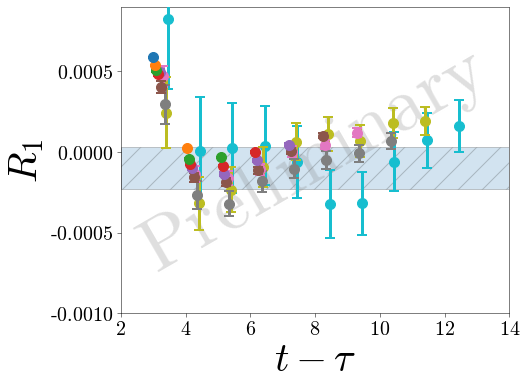

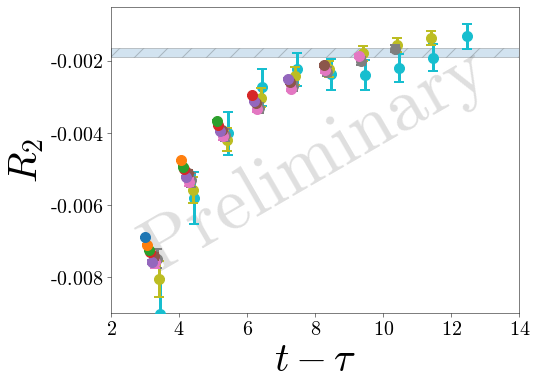

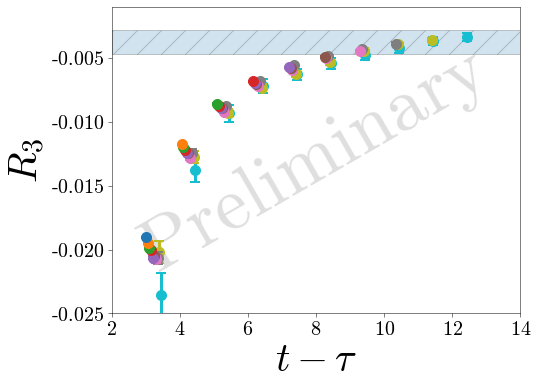

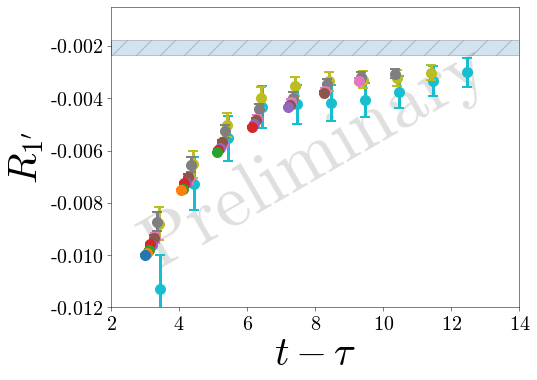

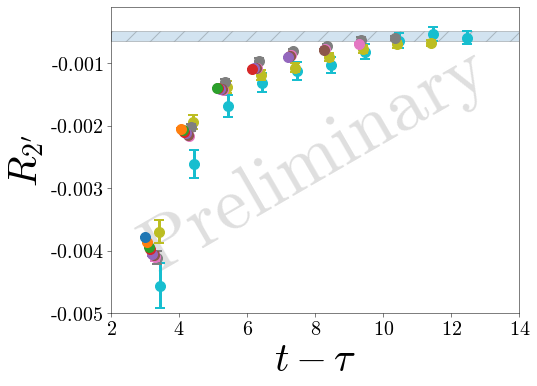

In [265]:
tsnk_max = 15
offset = 0.05
xrg = (2, 14)
# yrgs = [
#     (-0.001, 0.001), (5e-4, 0.02), (0.002, 0.05), (0.001, 0.02), (1e-4, 1e-2)
# ]
yrgs = [
    (-0.001, 0.0009), (-0.009, -5e-4), (-0.025, -0.001), (-0.012, -0.0005), (-0.005, -1e-4)
]
min_tsnk = np.min(tsnk)
for k in range(n_scalar_ops):
    fig, axes = pt.add_subplots(style = style)
    ax = axes[0]

    for ii in range(nsep):
        tsnki, txi = tsnk[ii], tx[ii]

        if tsnki > tsnk_max:
            continue

        x = tsnki - txi + offset * (tsnki - min_tsnk)
        y = data_bsm[ii, k] / means2[tsnki]
        plot_col = colors[tsnki - min_tsnk]
        pt.errorbar_1d([x], [gv.mean(y)], [gv.sdev(y)], ax = ax, col = plot_col, style = style, zorder = 100 - ii)

    xx = np.linspace(xrg[0], xrg[1], 100)
    yy = np.full(xx.shape, fit_results[k])
    ax.fill_between(xx, gv.mean(yy) - gv.sdev(yy), gv.mean(yy) + gv.sdev(yy), color = sns.color_palette()[0], \
                  alpha = 0.2, hatch = '/', edgecolor = 'k')

    ax.set_xlim(xrg)
    ax.set_ylim(yrgs[k])
    ax.set_xlabel(r'$t - \tau$')
    ax.set_ylabel(pretty_labels[k])
    
    pt.add_watermark(ax, style = style)

    #sub_patches = patches[:(tsnk_max - min_tsnk + 1)]
    #legend = plt.legend(title = r'$t$', handles = sub_patches, \
    #         fontsize = style['leg_fontsize'], bbox_to_anchor = leg_loc)
    #plt.setp(legend.get_title(), fontsize = style['leg_fontsize'])
    
    path = f'{out_dir}/{labels[k]}.pdf'
    pt.save_figure(path)
    print(f'Output saved to {path}.')

In [259]:
gv.sdev(fit_results) / gv.mean(fit_results)

array([-1.32925825, -0.07040913, -0.24677482, -0.14650309, -0.14650309])

## Vector operators

In [229]:
n_vector_ops = 4
fname = '/Users/theoares/Dropbox (MIT)/research/0nubb/nnpp/data/short_distance_plots_PRELIM/vector_data_to_plot.h5'
f = h5py.File(fname, 'r')

In [230]:
ncfgs = f['ncfgs'][()]
nsep = f['nsep'][()]
order = f['order'][()]
signs = f['signs'][()]

max_src_snk_sep = f['maxSourceSinkSep'][()]
tsnk = f['tsnk'][()]
tx = f['tx'][()]

means2 = f['means2'][()]
means_bsm = f['meansBSM'][()]
errors_bsm = f['errorsBSM'][()]
data_bsm = gv.gvar(means_bsm, errors_bsm)
fit_results = gv.gvar(f['fitResultsMean'][()], f['fitResultsSdev'][()])

In [231]:
out_dir = '/Users/theoares/Dropbox (MIT)/research/0nubb/nnpp/plots/talks'
labels = [op.decode() for op in order]
# pretty_labels = [r'$\mathcal{O}_1$', r'$\mathcal{O}_2$', r'$\mathcal{O}_3$', \
#                  r'$\mathcal{O}_{1^\prime}$', r'$\mathcal{O}_{2^\prime}$']
pretty_labels = [r'$R_{\mathcal{V}_1}$', r'$R_{\mathcal{V}_2}$', r'$R_{\mathcal{V}_3}$', \
                 r'$R_{\mathcal{V}_4}$']

In [241]:
style = styles['talk']
style['colwidth'] = 600.0 / pts_per_inch
style['asp_ratio'] = 4/3
style['fontsize'] = 40.0
# style['markersize'] = 10.0
style['tick_fontsize'] = 20.0
style['leg_fontsize'] = 25.0

style['markersize'] = 20
style['ebar_width'] = 3.0
style['endcaps'] = 5.0

style['wfontsize'] = 75

leg_loc = (1., 1.)
colors = sns.color_palette()
import matplotlib.colors
colors.append(matplotlib.colors.to_rgba('tan'))

min_tsnk = np.min(tsnk)
patches = [mpatches.Patch(color = colors[i], label = r'$' + str(i + min_tsnk) + '$') for i in range(len(colors))]

Output saved to /Users/theoares/Dropbox (MIT)/research/0nubb/nnpp/plots/talks/V1.pdf.
Output saved to /Users/theoares/Dropbox (MIT)/research/0nubb/nnpp/plots/talks/V2.pdf.
Output saved to /Users/theoares/Dropbox (MIT)/research/0nubb/nnpp/plots/talks/V3.pdf.
Output saved to /Users/theoares/Dropbox (MIT)/research/0nubb/nnpp/plots/talks/V4.pdf.


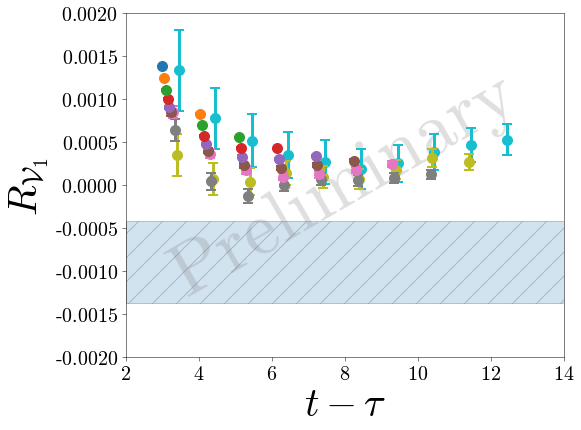

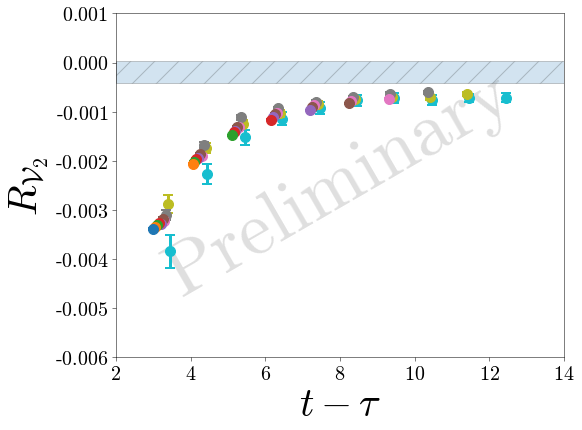

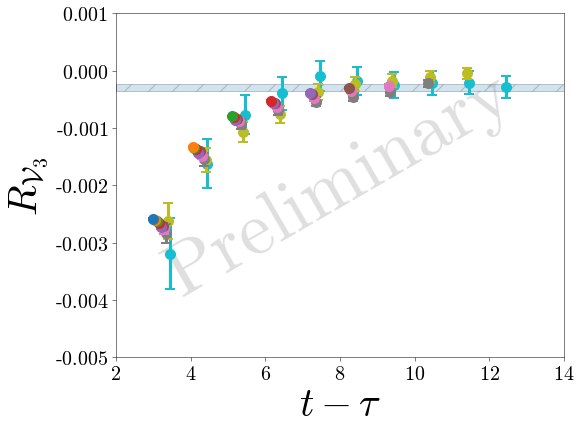

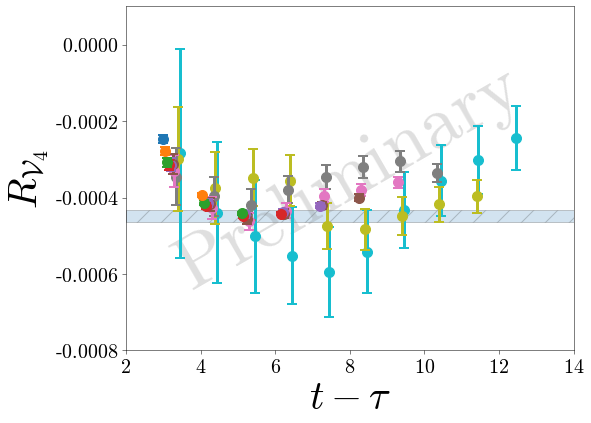

In [242]:
reload(pt)

tsnk_max = 15
offset = 0.05
xrg = (2, 14)
# yrgs = [
#     (-0.001, 0.001), (5e-4, 0.02), (0.002, 0.05), (0.001, 0.02), (1e-4, 1e-2)
# ]
yrgs = [
    (-0.002, 0.002), (-0.006, 0.001), (-0.005, 0.001), (-0.0008, 0.0001)
]
min_tsnk = np.min(tsnk)
for k in range(n_vector_ops):
    fig, axes = pt.add_subplots(style = style)
    ax = axes[0]

    for ii in range(nsep):
        tsnki, txi = tsnk[ii], tx[ii]

        if tsnki > tsnk_max:
            continue

        x = tsnki - txi + offset * (tsnki - min_tsnk)
        y = data_bsm[ii, k] / means2[tsnki]
        plot_col = colors[tsnki - min_tsnk]
        pt.errorbar_1d([x], [gv.mean(y)], [gv.sdev(y)], ax = ax, col = plot_col, style = style, zorder = 100 - ii)

    xx = np.linspace(xrg[0], xrg[1], 100)
    yy = np.full(xx.shape, fit_results[k])
    ax.fill_between(xx, gv.mean(yy) - gv.sdev(yy), gv.mean(yy) + gv.sdev(yy), color = sns.color_palette()[0], \
                  alpha = 0.2, hatch = '/', edgecolor = 'k')

    ax.set_xlim(xrg)
    ax.set_ylim(yrgs[k])
    ax.set_xlabel(r'$t - \tau$')
    ax.set_ylabel(pretty_labels[k])
    
    pt.add_watermark(ax, style = style)

    #sub_patches = patches[:(tsnk_max - min_tsnk + 1)]
    #legend = plt.legend(title = r'$t$', handles = sub_patches, \
    #         fontsize = style['leg_fontsize'], bbox_to_anchor = leg_loc)
    #plt.setp(legend.get_title(), fontsize = style['leg_fontsize'])
    
    path = f'{out_dir}/{labels[k]}.pdf'
    pt.save_figure(path)
    print(f'Output saved to {path}.')

In [236]:
gv.sdev(fit_results) / gv.mean(fit_results)

array([-0.54117323, -1.12606697, -0.2113766 , -0.03582628])